<a href="https://colab.research.google.com/github/SoYeoni621/mulcam/blob/master/CNN_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
data_path = '/content/drive/MyDrive/python/'
Input_train_data = 'nsmc_train_input.npy'
Label_train_data = 'nsmc_train_label.npy'
Data_configs = 'data_configs.json'

X_train = np.load(open(data_path + Input_train_data, 'rb'))
X_train = pad_sequences(X_train, maxlen=X_train.shape[1])
y_train = np.load(open(data_path + Label_train_data, 'rb'))
prepro_configs = json.load(open(data_path + Data_configs, 'r'))

In [ ]:
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'
SAVE_FILE_NAME = 'weights.h5'

X_test = np.load(open(data_path + INPUT_TEST_DATA, 'rb'))
X_test = pad_sequences(X_test, maxlen=X_test.shape[1])
y_test = np.load(open(data_path + LABEL_TEST_DATA, 'rb'))

In [ ]:
embedd = 'nsmc_embbedding_matrix.npy'

embedding_matrix = np.load(open(data_path + embedd, 'rb'))

# NonStatic CNN

In [ ]:
from keras.models import Model
from keras.layers import *
from keras.utils.np_utils import to_categorical

embedding_dim = 300
num_filters = 100

inputs = Input(shape=(maxlen, ), dtype='int32')

embedding_layer = Embedding(vocab_size, 
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=True)(inputs)
reshape = Reshape((maxlen, embedding_dim, 1))(embedding_layer)
conv1 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
conv2 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
conv3 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)

maxpool1 = MaxPool2D(pool_size=(maxlen - 3 +1, 1), strides=(1,1), padding='valid')(conv1)
maxpool2 = MaxPool2D(pool_size=(maxlen - 4 +1, 1), strides=(1,1), padding='valid')(conv2)
maxpool3 = MaxPool2D(pool_size=(maxlen - 5 +1, 1), strides=(1,1), padding='valid')(conv3)

concatenated = Concatenate(axis=1)([maxpool1, maxpool2, maxpool3])
flatten = Flatten()(concatenated)

dropout = Dropout(0.5)(flatten)
output = Dense(units=1, activation='softmax')(dropout)

In [ ]:
NonStatic = Model(inputs=inputs, outputs=output)
NonStatic.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
NonStatic.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 47)]         0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 47, 300)      14983500    ['input_7[0][0]']                
                                                                                                  
 reshape_5 (Reshape)            (None, 47, 300, 1)   0           ['embedding_5[0][0]']            
                                                                                                  
 conv2d_3 (Conv2D)              (None, 45, 1, 100)   90100       ['reshape_5[0][0]']              
                                                                                            

In [ ]:
# validation set 30000건 분리(전체 data의 약 20%)
X_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 118182건
partial_X_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(119995, 47)
(119995,)


In [ ]:
epochs = 20

cb_early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=4)

MODEL_SAVE_FOLDER = '/content/drive/MyDrive/python/'
checkpoint_path = MODEL_SAVE_FOLDER +  '/non-static-cnn-weights.h5'
cb_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
cb_model_path = MODEL_SAVE_FOLDER + 'nonstatic-best-model.h5'
model_cb = ModelCheckpoint(cb_model_path, monitor='val_accuracy', verbose=1, save_best_only=True)

history = NonStatic.fit(partial_X_train, partial_y_train, 
                 batch_size=256, epochs=epochs, validation_data=(X_val, y_val), 
                 callbacks=[model_cb, cb_early_stopping])

Epoch 1/20
469/469 [==============================] - ETA: 0s - loss: 1377.1005 - accuracy: 0.4989
Epoch 1: val_accuracy improved from -inf to 0.49853, saving model to /content/drive/MyDrive/python/nonstatic-best-model.h5
469/469 [==============================] - 67s 123ms/step - loss: 1377.1005 - accuracy: 0.4989 - val_loss: 6288.9780 - val_accuracy: 0.4985
Epoch 2/20
469/469 [==============================] - ETA: 0s - loss: 31791.3086 - accuracy: 0.4989
Epoch 2: val_accuracy did not improve from 0.49853
469/469 [==============================] - 34s 72ms/step - loss: 31791.3086 - accuracy: 0.4989 - val_loss: 77456.9062 - val_accuracy: 0.4985
Epoch 3/20
469/469 [==============================] - ETA: 0s - loss: 179066.4688 - accuracy: 0.4989
Epoch 3: val_accuracy did not improve from 0.49853
469/469 [==============================] - 33s 70ms/step - loss: 179066.4688 - accuracy: 0.4989 - val_loss: 321391.5625 - val_accuracy: 0.4985
Epoch 4/20
469/469 [==============================]

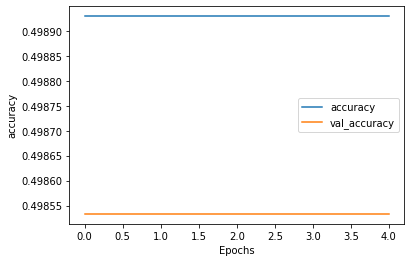

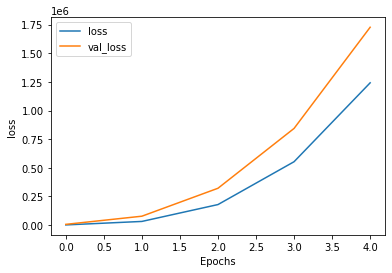

In [ ]:
def plot_graphs(hist, string):
    plt.plot(hist.history[string])
    plt.plot(hist.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
# 50.35% 성능
NonStatic.evaluate(X_test, y_test)

1563/1563 [==============================] - 10s 6ms/step - loss: 1727155.3750 - accuracy: 0.5035


[1727155.375, 0.5034502148628235]

# Static CNN

In [ ]:
from keras.models import Model
from keras.layers import *
from keras.utils.np_utils import to_categorical

embedding_dim = 300
num_filters = 100

inputs2 = Input(shape=(maxlen, ), dtype='int32')

embedding_layer2 = Embedding(vocab_size, 
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)(inputs2)
reshape2 = Reshape((maxlen, embedding_dim, 1))(embedding_layer2)
conv2_1 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape2)
conv2_2 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape2)
conv2_3 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape2)

maxpool2_1 = MaxPool2D(pool_size=(maxlen - 3 +1, 1), strides=(1,1), padding='valid')(conv2_1)
maxpool2_2 = MaxPool2D(pool_size=(maxlen - 4 +1, 1), strides=(1,1), padding='valid')(conv2_2)
maxpool2_3 = MaxPool2D(pool_size=(maxlen - 5 +1, 1), strides=(1,1), padding='valid')(conv2_3)

concatenated2 = Concatenate(axis=1)([maxpool2_1, maxpool2_2, maxpool2_3])
flatten2 = Flatten()(concatenated2)

dropout2 = Dropout(0.5)(flatten2)
output2 = Dense(units=1, activation='softmax')(dropout2)

In [ ]:
Static = Model(inputs=inputs2, outputs=output2)
Static.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
Static.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 47)]         0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 47, 300)      14983500    ['input_9[0][0]']                
                                                                                                  
 reshape_7 (Reshape)            (None, 47, 300, 1)   0           ['embedding_7[0][0]']            
                                                                                                  
 conv2d_9 (Conv2D)              (None, 45, 1, 100)   90100       ['reshape_7[0][0]']              
                                                                                            

In [ ]:
epochs = 20

cb_early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=4)

MODEL_SAVE_FOLDER = '/content/drive/MyDrive/python/'
checkpoint_path = MODEL_SAVE_FOLDER +  '/static-cnn-weights.h5'
cb_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
cb_model_path = MODEL_SAVE_FOLDER + 'nonstatic-best-model.h5'
model_cb = ModelCheckpoint(cb_model_path, monitor='val_accuracy', verbose=1, save_best_only=True)

history = Static.fit(partial_X_train, partial_y_train, 
                 batch_size=256, epochs=epochs, validation_data=(X_val, y_val), 
                 callbacks=[model_cb, cb_early_stopping])

Epoch 1/20
468/469 [============================>.] - ETA: 0s - loss: 233.2208 - accuracy: 0.4988
Epoch 1: val_accuracy improved from -inf to 0.49853, saving model to /content/drive/MyDrive/python/nonstatic-best-model.h5
469/469 [==============================] - 49s 103ms/step - loss: 233.9938 - accuracy: 0.4989 - val_loss: 729.4559 - val_accuracy: 0.4985
Epoch 2/20
469/469 [==============================] - ETA: 0s - loss: 1558.1616 - accuracy: 0.4989
Epoch 2: val_accuracy did not improve from 0.49853
469/469 [==============================] - 19s 40ms/step - loss: 1558.1616 - accuracy: 0.4989 - val_loss: 2644.1433 - val_accuracy: 0.4985
Epoch 3/20
469/469 [==============================] - ETA: 0s - loss: 4084.8997 - accuracy: 0.4989
Epoch 3: val_accuracy did not improve from 0.49853
469/469 [==============================] - 18s 39ms/step - loss: 4084.8997 - accuracy: 0.4989 - val_loss: 5654.3735 - val_accuracy: 0.4985
Epoch 4/20
469/469 [==============================] - ETA: 0s -

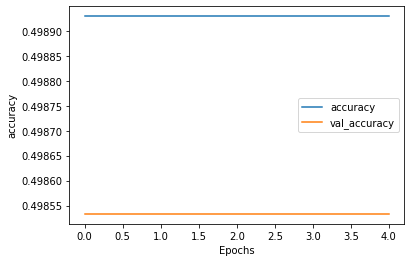

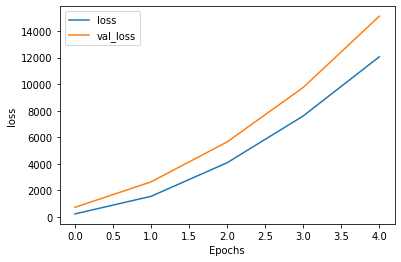

In [ ]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
Static.evaluate(X_test, y_test)

1563/1563 [==============================] - 10s 6ms/step - loss: 15117.2939 - accuracy: 0.5035


[15117.2939453125, 0.5034502148628235]